# Tutorial de GraphRAG implementado para a leitura de uma base de dados relacional

Notebooks desenvolvido com base nos links abaixo:
- [Building Knowledge Graphs with LLM Graph Transformer](https://medium.com/data-science/building-knowledge-graphs-with-llm-graph-transformer-a91045c49b59)
- [llm_graph_transformer_in_depth.ipynb](https://github.com/tomasonjo/blogs/blob/master/llm/llm_graph_transformer_in_depth.ipynb)


Materiais úteis:
- [Graph Database vs Relational Database](https://memgraph.com/blog/graph-database-vs-relational-database)
- [Tutorial GraphRAG using Langchain and Oracle Graph on Oracle Database 23ai (Part 1)](https://medium.com/oracledevs/graphrag-using-langchain-and-oracle-graph-on-oracle-database-23ai-part-1-dc76b48a4ca1)
- [Implementing Knowledge Graphs with MongoDB](https://pureinsights.com/blog/2023/implementing-knowledge-graphs-with-mongodb/)
- [RAG over Structured Data (Graph & Relational)](https://victormorgante.medium.com/rag-over-structured-data-graph-relational-86d39a241270)
- [Using a Knowledge Graph to Implement a RAG Applicatio](https://www.datacamp.com/tutorial/knowledge-graph-rag)
- [Constructing knowledge graphs from text using OpenAI functions](https://bratanic-tomaz.medium.com/constructing-knowledge-graphs-from-text-using-openai-functions-096a6d010c17)
- [Day 10: Knowledge Graphs for RAG](https://blog.gopenai.com/day-10-knowledge-graphs-for-rag-8ca1691b56e2)

- [mongodb-graph](https://github.com/ranfysvalle02/mongodb-graph)

https://www.mongodb.com/developer/products/atlas/parent-doc-retrieval/

https://medium.com/mongodb/knowledge-graph-rag-using-mongodb-1346e953064c

## Imports e carregamento de variáveis de ambiente

In [1]:
from src.settings import BASE_DIR, SQLITE_DB_NAME, MONGO_URI, MONGO_DB_NAME, MONGO_COLLECTION
from src.utils.dataviz import plot_graph_documents

## Criando base de dados relacional com SQLite

### Conectando, criando e populando tabelas no sqlite
Primeiro, vamos importar a biblioteca sqlite3 e estabelecer uma conexão com o banco de dados SQLite. Se o arquivo do banco de dados não existir, ele será criado automaticamente.

Criando e populando tabelas conforme base de dados disponível em:
- https://www.kaggle.com/datasets/dillonmyrick/bike-store-sample-database?select=stores.csv
- https://www.sqlservertutorial.net/getting-started/sql-server-sample-database/


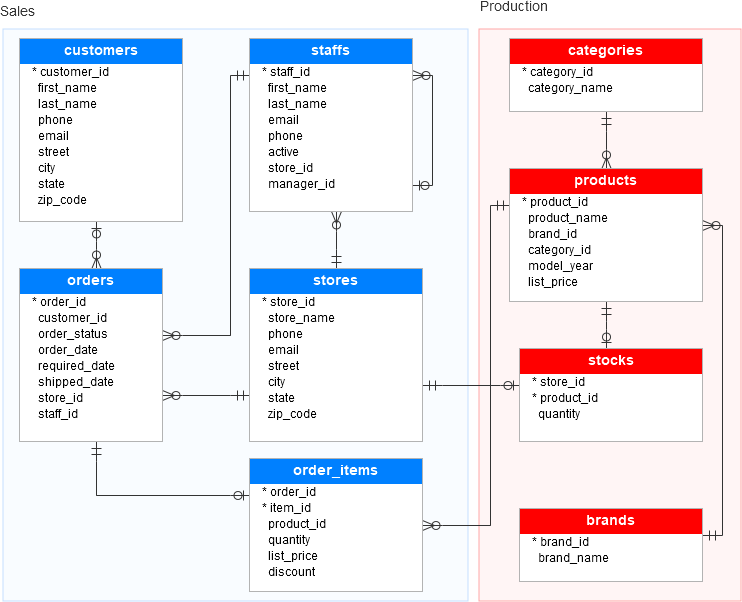

In [ ]:
# import sqlite3

# # Conectar ao banco de dados SQLite (será criado se não existir)
# connection = sqlite3.connect(SQLITE_DB_NAME)
# cursor = connection.cursor()

# BASE_PATH_SQL = "data/sql/bike_store"

# files = ["create", "insert"]
# for file_name in files:
#     with open(f'{BASE_PATH_SQL}/{file_name}.sql', 'r') as f:
#         schema_sql = f.read()

#         cursor.executescript(schema_sql)

# connection.commit()
# connection.close()


### Consultando os Dados
Para consultar os dados inseridos e verificar as informações, podemos executar uma simples consulta SQL:

In [ ]:
import sqlite3

db_path = f"{BASE_DIR}/data/sqlite/{SQLITE_DB_NAME}"
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

cursor.execute("""
    SELECT *
    FROM stores
""")

for row in cursor.fetchall():
    print(row)

connection.close()

/home/mrs2/git/estudos/graph_rag/data/sqlite/bike_store.db
(1, 'Santa Cruz Bikes', '(831) 476-4321', 'santacruz@bikes.shop', '3700 Portola Drive', 'Santa Cruz', 'CA', '95060')
(2, 'Baldwin Bikes', '(516) 379-8888', 'baldwin@bikes.shop', '4200 Chestnut Lane', 'Baldwin', 'NY', '11432')
(3, 'Rowlett Bikes', '(972) 530-5555', 'rowlett@bikes.shop', '8000 Fairway Avenue', 'Rowlett', 'TX', '75088')


## Extraindo documentos baseados em grafos de um texto com ajuda do LLMGraphTransformer

In [ ]:
from langchain_core.documents import Document

sql_text = """
-- Tabelas convertidas para SQLite

CREATE TABLE categories (
	category_id INTEGER PRIMARY KEY AUTOINCREMENT,
	category_name TEXT NOT NULL
);

CREATE TABLE brands (
	brand_id INTEGER PRIMARY KEY AUTOINCREMENT,
	brand_name TEXT NOT NULL
);

CREATE TABLE products (
	product_id INTEGER PRIMARY KEY AUTOINCREMENT,
	product_name TEXT NOT NULL,
	brand_id INTEGER NOT NULL,
	category_id INTEGER NOT NULL,
	model_year INTEGER NOT NULL,
	list_price REAL NOT NULL,
	FOREIGN KEY (category_id) REFERENCES categories (category_id) ON DELETE CASCADE ON UPDATE CASCADE,
	FOREIGN KEY (brand_id) REFERENCES brands (brand_id) ON DELETE CASCADE ON UPDATE CASCADE
);

CREATE TABLE customers (
	customer_id INTEGER PRIMARY KEY AUTOINCREMENT,
	first_name TEXT NOT NULL,
	last_name TEXT NOT NULL,
	phone TEXT,
	email TEXT NOT NULL,
	street TEXT,
	city TEXT,
	state TEXT,
	zip_code TEXT
);

CREATE TABLE stores (
	store_id INTEGER PRIMARY KEY AUTOINCREMENT,
	store_name TEXT NOT NULL,
	phone TEXT,
	email TEXT,
	street TEXT,
	city TEXT,
	state TEXT,
	zip_code TEXT
);

CREATE TABLE staffs (
	staff_id INTEGER PRIMARY KEY AUTOINCREMENT,
	first_name TEXT NOT NULL,
	last_name TEXT NOT NULL,
	email TEXT NOT NULL UNIQUE,
	phone TEXT,
	active INTEGER NOT NULL,
	store_id INTEGER NOT NULL,
	manager_id INTEGER,
	FOREIGN KEY (store_id) REFERENCES stores (store_id) ON DELETE CASCADE ON UPDATE CASCADE,
	FOREIGN KEY (manager_id) REFERENCES staffs (staff_id) ON DELETE NO ACTION ON UPDATE NO ACTION
);

CREATE TABLE orders (
	order_id INTEGER PRIMARY KEY AUTOINCREMENT,
	customer_id INTEGER,
	order_status INTEGER NOT NULL, -- 1=Pending, 2=Processing, 3=Rejected, 4=Completed
	order_date TEXT NOT NULL,
	required_date TEXT NOT NULL,
	shipped_date TEXT,
	store_id INTEGER NOT NULL,
	staff_id INTEGER NOT NULL,
	FOREIGN KEY (customer_id) REFERENCES customers (customer_id) ON DELETE CASCADE ON UPDATE CASCADE,
	FOREIGN KEY (store_id) REFERENCES stores (store_id) ON DELETE CASCADE ON UPDATE CASCADE,
	FOREIGN KEY (staff_id) REFERENCES staffs (staff_id) ON DELETE NO ACTION ON UPDATE NO ACTION
);

CREATE TABLE order_items (
	order_id INTEGER,
	item_id INTEGER,
	product_id INTEGER NOT NULL,
	quantity INTEGER NOT NULL,
	list_price REAL NOT NULL,
	discount REAL NOT NULL DEFAULT 0,
	PRIMARY KEY (order_id, item_id),
	FOREIGN KEY (order_id) REFERENCES orders (order_id) ON DELETE CASCADE ON UPDATE CASCADE,
	FOREIGN KEY (product_id) REFERENCES products (product_id) ON DELETE CASCADE ON UPDATE CASCADE
);

CREATE TABLE stocks (
	store_id INTEGER,
	product_id INTEGER,
	quantity INTEGER,
	PRIMARY KEY (store_id, product_id),
	FOREIGN KEY (store_id) REFERENCES stores (store_id) ON DELETE CASCADE ON UPDATE CASCADE,
	FOREIGN KEY (product_id) REFERENCES products (product_id) ON DELETE CASCADE ON UPDATE CASCADE
);
"""

sql_documents =  [Document(page_content=sql_text)]

In [25]:
from langchain_openai import ChatOpenAI
from langchain_experimental.graph_transformers import LLMGraphTransformer

model="gpt-4o-mini"
llm = ChatOpenAI(model=model)

[GraphDocument(nodes=[Node(id='Categories', type='Table', properties={}), Node(id='Brands', type='Table', properties={}), Node(id='Products', type='Table', properties={}), Node(id='Customers', type='Table', properties={}), Node(id='Stores', type='Table', properties={}), Node(id='Staffs', type='Table', properties={}), Node(id='Orders', type='Table', properties={}), Node(id='Order_Items', type='Table', properties={}), Node(id='Stocks', type='Table', properties={})], relationships=[Relationship(source=Node(id='Products', type='Table', properties={}), target=Node(id='Brands', type='Table', properties={}), type='FOREIGN_KEY', properties={}), Relationship(source=Node(id='Products', type='Table', properties={}), target=Node(id='Categories', type='Table', properties={}), type='FOREIGN_KEY', properties={}), Relationship(source=Node(id='Orders', type='Table', properties={}), target=Node(id='Customers', type='Table', properties={}), type='FOREIGN_KEY', properties={}), Relationship(source=Node(id=

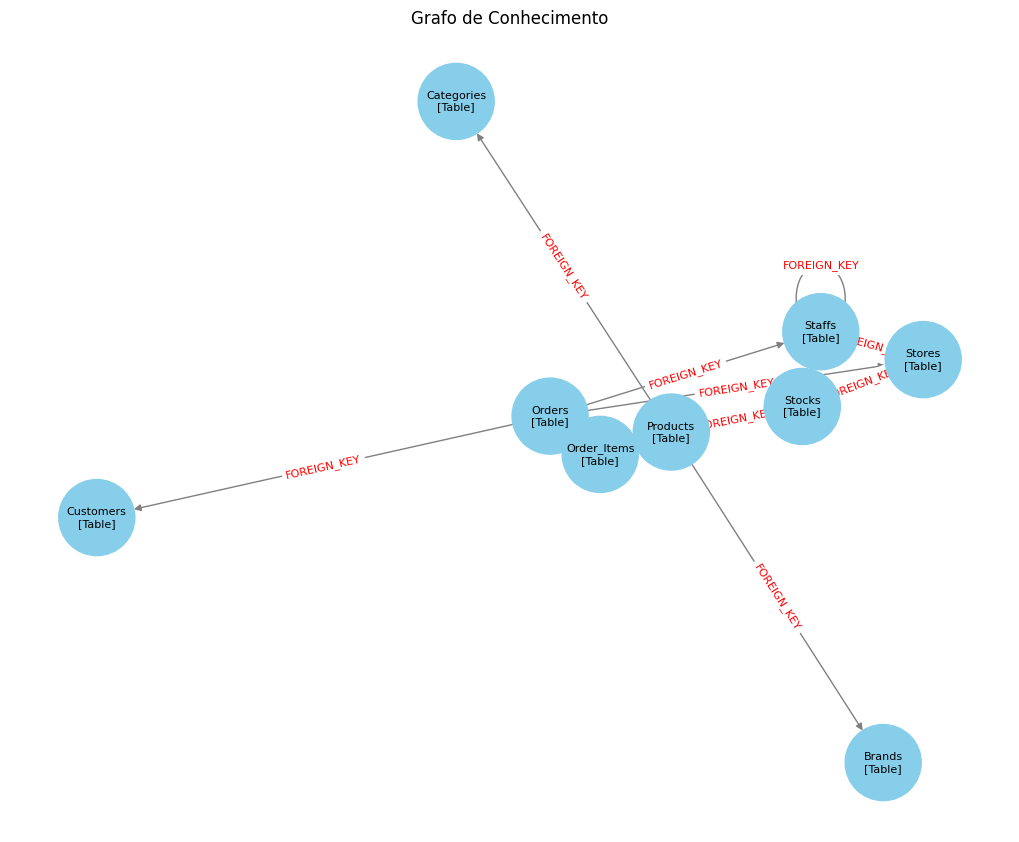

In [101]:

no_schema = LLMGraphTransformer(llm=llm)
data = await no_schema.aconvert_to_graph_documents(sql_documents)

print(data)
plot_graph_documents(data)